In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt


from tensorflow.python.framework import dtypes
from tensorflow.contrib import learn

import logging
logging.basicConfig(level=logging.INFO)


from tensorflow.contrib import learn
from sklearn.metrics import mean_squared_error


In [2]:
LOG_DIR = './ops_logs'
TIMESTEPS = 5
RNN_LAYERS = [{'steps': TIMESTEPS}]
DENSE_LAYERS = None
TRAINING_STEPS = 10000
BATCH_SIZE = 100
PRINT_STEPS = TRAINING_STEPS / 100

In [3]:
def lstm_model(time_steps, rnn_layers, dense_layers=None):
    def lstm_cells(layers):
        return [tf.nn.rnn_cell.BasicLSTMCell(layer['steps'],state_is_tuple=True)
                for layer in layers]

    def dnn_layers(input_layers, layers):
            return input_layers

    def _lstm_model(X, y):
        stacked_lstm = tf.nn.rnn_cell.MultiRNNCell(lstm_cells(rnn_layers), state_is_tuple=True)
        x_ = learn.ops.split_squeeze(1, time_steps, X)
        output, layers = tf.nn.rnn(stacked_lstm, x_, dtype=dtypes.float32)
        output = dnn_layers(output[-1], dense_layers)
        return learn.models.linear_regression(output, y)

    return _lstm_model

In [4]:
regressor = learn.TensorFlowEstimator(model_fn=lstm_model(TIMESTEPS, RNN_LAYERS, DENSE_LAYERS), n_classes=0,
                                      verbose=2,  steps=TRAINING_STEPS, optimizer='Adagrad',
                                      learning_rate=0.03, batch_size=BATCH_SIZE)

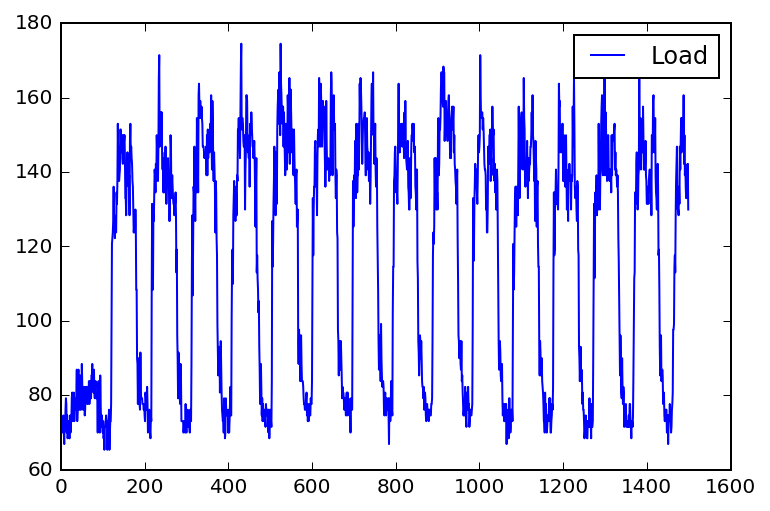

In [5]:
df = pd.read_csv("data/elec_load.csv", error_bad_lines=False)
plt.subplot()
plot_test, = plt.plot(df.values[:1500], label='Load')
plt.legend(handles=[plot_test])

                Load
count  140256.000000
mean      145.332503
std        48.477976
min         0.000000
25%       106.850998
50%       151.428571
75%       177.557604
max       338.218126


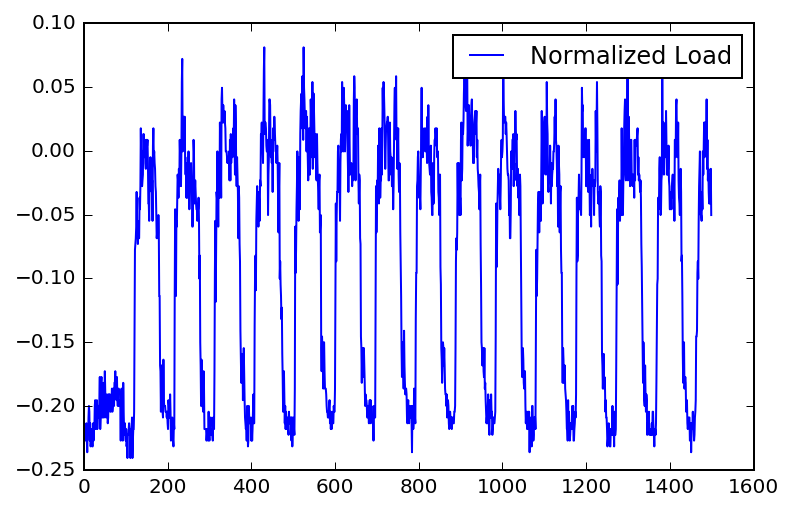

In [6]:
print df.describe()
array=(df.values- 147.0) /339.0
plt.subplot()
plot_test, = plt.plot(array[:1500], label='Normalized Load')
plt.legend(handles=[plot_test])


In [7]:


listX = []
listy = []
X={}
y={}

for i in range(0,len(array)-6):
    listX.append(array[i:i+5].reshape([5,1]))
    listy.append(array[i+6])

arrayX=np.array(listX)
arrayy=np.array(listy)


X['train']=arrayX[0:12000]
X['test']=arrayX[12000:13000]
X['val']=arrayX[13000:14000]

y['train']=arrayy[0:12000]
y['test']=arrayy[12000:13000]
y['val']=arrayy[13000:14000]


In [8]:
# print y['test'][0]
# print y2['test'][0]

In [9]:
#X1, y2 = generate_data(np.sin, np.linspace(0, 100, 10000), TIMESTEPS, seperate=False)
# create a lstm instance and validation monitor
validation_monitor = learn.monitors.ValidationMonitor(X['val'], y['val'],
                                                      every_n_steps=PRINT_STEPS,
                                                      early_stopping_rounds=1000)

In [10]:
#print (X1['train'][1])
#print (X)
#print X['train'][0]

In [11]:
regressor.fit(X['train'], y['train'], monitors=[validation_monitor], logdir=LOG_DIR)

TensorFlowEstimator(continue_training=False, optimizer=Adagrad, verbose=2, learning_rate=0.03, batch_size=100, steps=10000, n_classes=0, params=None, clip_gradients=5.0, class_weight=None)

In [12]:
predicted = regressor.predict(X['test'])
rmse = np.sqrt(((predicted - y['test']) ** 2).mean(axis=0))
score = mean_squared_error(predicted, y['test'])
print ("MSE: %f" % score)

MSE: 0.001139


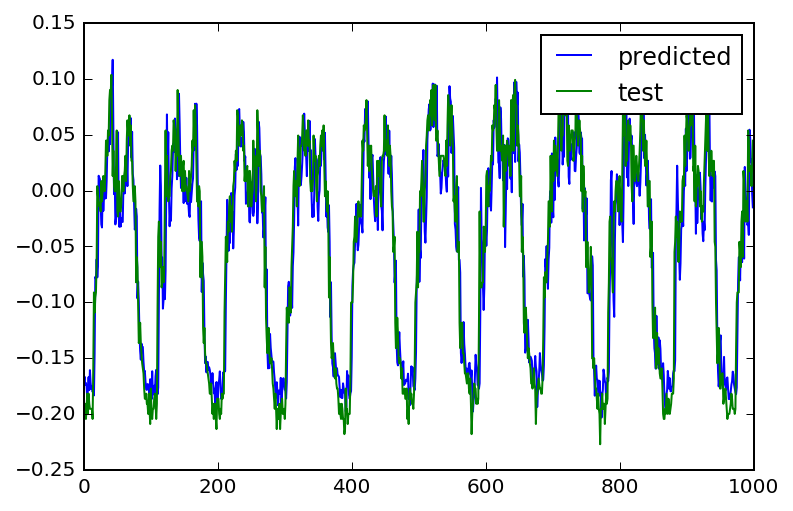

In [13]:
#plot_predicted, = plt.plot(array[:1000], label='predicted')

plt.subplot()
plot_predicted, = plt.plot(predicted, label='predicted')

plot_test, = plt.plot(y['test'], label='test')
plt.legend(handles=[plot_predicted, plot_test])